## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.experimental import FourierSPIRIT
from deepmeg.interpreters import SPIRITInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp
from deepmeg.utils.colors import generate_cmap
from deepmeg.utils.params import SPIRITParameters

## Reading Epochs and preprocessing

In [2]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.resample(600).crop(0, None)
info = epochs.info

## Create a dataset containig epoched data

In [4]:
# dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
# dataset = EpochsDataset.load('../data/simulated_n2.pt')
dataset = EpochsDataset.load('../data/multimodal.pt')
# del raw, epochs, epochs_list
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [3]:
from mne.datasets import sample
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_raw = meg_path / 'sample_audvis_raw.fif'

info = mne.io.read_raw_fif(fname_raw).resample(200).pick_types(meg='grad').info

In [5]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [6]:
X, y = next(iter(DataLoader(test, len(test))))
X.shape
y.shape

torch.Size([282, 8])

## Compile the model

In [7]:
model = FourierSPIRIT(
    n_channels=X.shape[1], # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=X.shape[-1], # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    window_size=20,
    latent_dim=10,
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=y.shape[1] # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

## Training the model

  0%|          | 0/15 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.7124   |    binary_accuracy_train:  0.6548   |    loss_val:  0.6299   |    binary_accuracy_val:  0.7830
Epoch 1:  loss_train:  0.5966   |    binary_accuracy_train:  0.8055   |    loss_val:  0.5368   |    binary_accuracy_val:  0.8750
Epoch 2:  loss_train:  0.5140   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4746   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.4603   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4372   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.4292   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4178   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.4138   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4099   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.4078   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4079   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.4052   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4071   | 

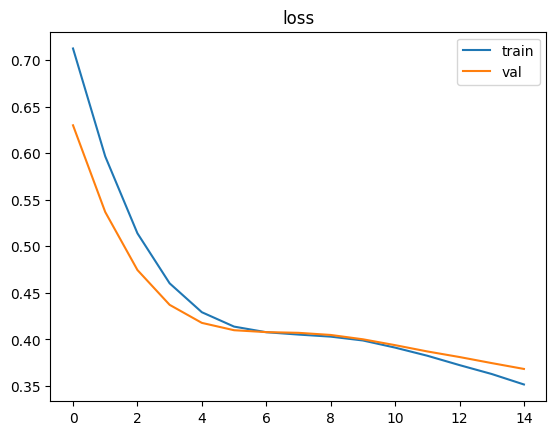

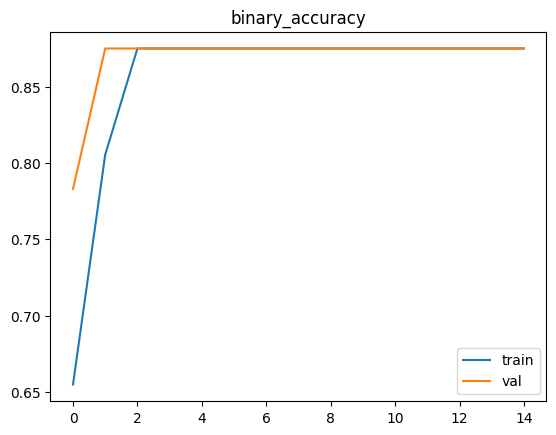

In [8]:
history = model.fit(train, n_epochs=15, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [9]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.34550605849786237
train_binary_accuracy: 0.8753496516834606
loss: 0.3718040016564456
binary_accuracy: 0.875


## Model interpretation

In [10]:
interpreter = SPIRITInterpreter(model, test, info)

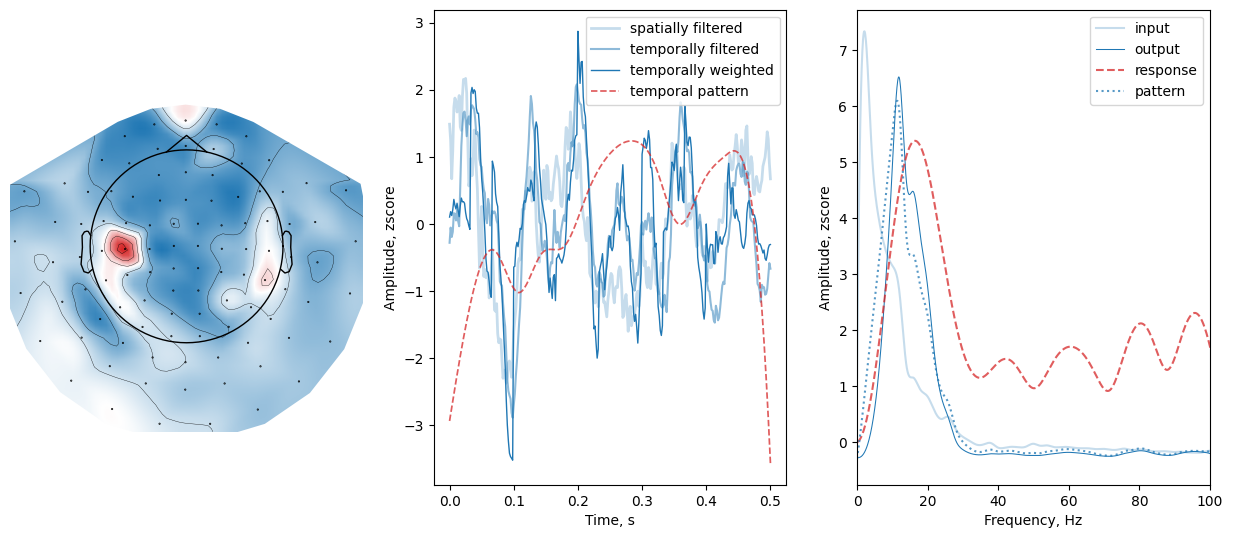

In [11]:
%matplotlib inline

fig = interpreter.plot_branch(0, ['input', 'output', 'response', 'pattern'])

In [32]:
from deepmeg.utils.params import LFCNNParameters, SpatialParameters, SpectralParameters, TemporalParameters, compute_induceds

class SPIRITParameters(LFCNNParameters):

    def __init__(self, interpreter: SPIRITInterpreter):
        self._info = interpreter.info
        self._spatial = SpatialParameters(interpreter.spatial_patterns, interpreter.spatial_filters)
        self._spectral = SpectralParameters(
            interpreter.frequency_range,
            interpreter.filter_inputs,
            interpreter.filter_outputs,
            interpreter.filter_responses,
            interpreter.filter_patterns
        )
        times = np.arange(0, interpreter.latent_sources.shape[-1]/interpreter.info['sfreq'], 1/interpreter.info['sfreq'])
        spectrums, spectrums_filtered = compute_induceds(interpreter)
        branch_tempwise_estimate = interpreter.temporal_patterns.mean(0)
        interp_cubic = lambda y: sp.interpolate.interp1d(np.linspace(0, times[-1], y.shape[1]), y, 'cubic')(times)

        self._temporal = TemporalParameters(
            times,
            interpreter.latent_sources,
            interpreter.latent_sources_filtered,
            spectrums, spectrums_filtered,
            interp_cubic(branch_tempwise_estimate)
        )
        self._branchwise_loss = interpreter.branchwise_loss

In [12]:
params = SPIRITParameters(interpreter)

In [13]:
from deepmeg.utils.viz import InterpretationPlotter

QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:363: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if summarize == 'sum':
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'sumabs':
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:367: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'abssum':


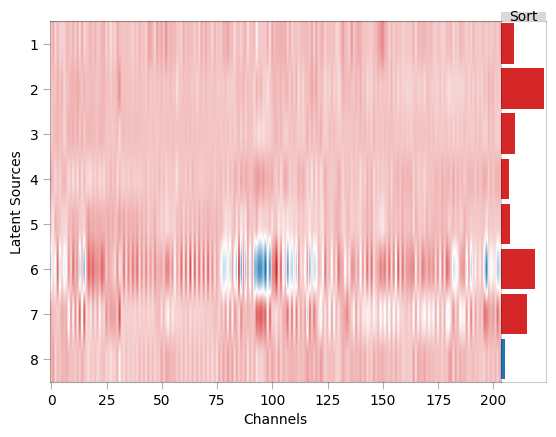

/home/user/Projects/deepmeg/deepmeg/utils/viz.py:517: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax24.set_xticklabels(times)
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:517: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax24.set_xticklabels(times)
/home/user/Projects/deepmeg/deepmeg/utils/viz.py:517: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax24.set_xticklabels(times)


In [14]:
%matplotlib qt

plotter = InterpretationPlotter(params, params.order)
plotter.plot()
